In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/GEE_exports_Houston"
cat1_dir = os.path.join(base_path, "Cat1_NPZ")
cat2_dir = os.path.join(base_path, "Cat2_NPZ")
cat3_dir = os.path.join(base_path, "Cat3_NPZ")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class FloodDataset(Dataset):
    def __init__(self, cat1_dir, cat2_dir, cat3_dir, selected_indices, transform=None):
        self.samples = []
        self.transform = transform

        for label, path in enumerate([cat3_dir, cat1_dir, cat2_dir]):
            files = sorted(os.listdir(path))
            for i in selected_indices:
                if i < len(files):
                    self.samples.append((os.path.join(path, files[i]), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        data = np.load(file_path)

        rainfall = data["rainfall"].astype(np.float32)   
        spatial = np.nan_to_num(data["spatial"].astype(np.float32), nan=0.0) 

        selected_channel_indices = [0, 2, 3, 4, 7, 8]
        spatial = spatial[selected_channel_indices, :, :]    
        mask = np.nan_to_num(data["mask"].astype(np.float32), nan=0.0)         

        rainfall_tensor = torch.tensor(rainfall)

        if self.transform:
          augmented = self.transform(
            image=spatial.transpose(1, 2, 0), 
            mask=mask                         
          )
          spatial_tensor = augmented["image"]                
          spatial_tensor = torch.nan_to_num(spatial_tensor, nan=0.0)
          mask_tensor = augmented["mask"].unsqueeze(0)      
        else:
            spatial_tensor = torch.tensor(spatial)
            mask_tensor = torch.tensor(mask).unsqueeze(0)

        return rainfall_tensor, spatial_tensor, mask_tensor, label


In [ ]:
from torch.utils.data import Subset

def stratified_split(dataset, label_value, train_ratio=0.7, val_ratio=0.2):
    indices = [i for i, (_, _, _, lbl) in enumerate(dataset) if lbl == label_value]
    total = len(indices)
    train_len = int(train_ratio * total)
    val_len = int(val_ratio * total)
    test_len = total - train_len - val_len

    return (
        Subset(dataset, indices[:train_len]),
        Subset(dataset, indices[train_len:train_len + val_len]),
        Subset(dataset, indices[train_len + val_len:])
    )


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.4),
    A.RandomRotate90(p=0.4),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),
    A.GridDistortion(p=0.2),
    A.Normalize(),
    ToTensorV2()
])



/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-5-bc5bd0e20207>:29: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),


In [ ]:
selected_indices = [0, 2, 3, 4, 7, 8]  

dataset_all = FloodDataset(cat1_dir, cat2_dir, cat3_dir, selected_indices, transform=None)  


train_cat1, val_cat1, test_cat1 = stratified_split(dataset_all, label_value=1)
train_cat2, val_cat2, test_cat2 = stratified_split(dataset_all, label_value=2)
train_cat3, val_cat3, test_cat3 = stratified_split(dataset_all, label_value=0)

from torch.utils.data import ConcatDataset

train_cat1.dataset.transform = train_augment
train_cat2.dataset.transform = train_augment
train_cat3.dataset.transform = train_augment

train_dataset = ConcatDataset([train_cat1, train_cat2, train_cat3])  

val_dataset = ConcatDataset([val_cat1, val_cat2, val_cat3])
test_dataset = ConcatDataset([test_cat1, test_cat2, test_cat3])



In [ ]:
from torch.utils.data import DataLoader

batch_size = 2  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)


In [ ]:
rain, spatial, mask, label = next(iter(train_loader))
print("Rainfall:", rain.shape)
print("Spatial:", spatial.shape)
print("Mask:", mask.shape)
print("Label (category):", label)


Rainfall: torch.Size([2, 24, 1])
Spatial: torch.Size([2, 6, 512, 512])
Mask: torch.Size([2, 1, 512, 512])
Label (category): tensor([2, 0])


In [ ]:
for rainfall, spatial, mask, label in train_loader:
    print("Label (category):", label)
    break


Label (category): tensor([1, 2])


In [ ]:
seen_labels = set()
for _, _, _, labels in train_loader:
    seen_labels.update(labels.tolist())

print("Categories seen in this epoch:", seen_labels)


Categories seen in this epoch: {0, 1, 2}


 GRU + U-Net++ Model (with Attention Fusion)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels, base_ch=64):
        super().__init__()
        
        self.conv00 = ConvBlock(in_channels, base_ch)
        self.pool0 = nn.MaxPool2d(2)
        self.conv10 = ConvBlock(base_ch, base_ch*2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv20 = ConvBlock(base_ch*2, base_ch*4)
        self.pool2 = nn.MaxPool2d(2)
        self.conv30 = ConvBlock(base_ch*4, base_ch*8)
        self.pool3 = nn.MaxPool2d(2)
        self.conv40 = ConvBlock(base_ch*8, base_ch*16)

        self.up01 = ConvBlock(base_ch + base_ch*2, base_ch)
        self.up11 = ConvBlock(base_ch*2 + base_ch*4, base_ch*2)
        self.up21 = ConvBlock(base_ch*4 + base_ch*8, base_ch*4)
        self.up31 = ConvBlock(base_ch*8 + base_ch*16, base_ch*8)

        self.final = nn.Conv2d(base_ch, 1, kernel_size=1)

    def forward(self, x):
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool0(x00))
        x20 = self.conv20(self.pool1(x10))
        x30 = self.conv30(self.pool2(x20))
        x40 = self.conv40(self.pool3(x30))

        x31 = self.up31(torch.cat([F.interpolate(x40, scale_factor=2, mode='bilinear', align_corners=True), x30], dim=1))
        x21 = self.up21(torch.cat([F.interpolate(x31, scale_factor=2, mode='bilinear', align_corners=True), x20], dim=1))
        x11 = self.up11(torch.cat([F.interpolate(x21, scale_factor=2, mode='bilinear', align_corners=True), x10], dim=1))
        x01 = self.up01(torch.cat([F.interpolate(x11, scale_factor=2, mode='bilinear', align_corners=True), x00], dim=1))

        return self.final(x01)  

In [ ]:

class GRU_UNetPP(nn.Module):
    def __init__(self, spatial_in_channels=6, rainfall_input_dim=1,
                 gru_hidden=64, gru_layers=1, cnn_channels=64):
        super(GRU_UNetPP, self).__init__()

        self.gru = nn.GRU(
            input_size=rainfall_input_dim,
            hidden_size=gru_hidden,
            num_layers=gru_layers,
            batch_first=True
        )

        self.encoder = nn.Sequential(
            nn.Conv2d(spatial_in_channels, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(cnn_channels, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(cnn_channels, cnn_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(cnn_channels // 2, 1, kernel_size=1)
        )

        self.fusion_fc = nn.Linear(gru_hidden, cnn_channels)

    def forward(self, rainfall, spatial):
        
        rainfall_feat, _ = self.gru(rainfall)  
        rainfall_feat = rainfall_feat[:, -1, :]  
        rainfall_feat = self.fusion_fc(rainfall_feat)  
        rainfall_feat = rainfall_feat.unsqueeze(-1).unsqueeze(-1)  
        rainfall_feat = rainfall_feat.expand(-1, -1, 512, 512)    

        spatial_feat = self.encoder(spatial)

        fused = spatial_feat * rainfall_feat  

        out = self.decoder(fused)
        out = out.squeeze(1)  
        return out


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GRU_UNetPP(spatial_in_channels=6, rainfall_input_dim=1).to(device)


FocalLoss with Label Smoothing

In [ ]:
class WeightedBCEFocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, lambda_bce=0.5, lambda_focal=0.5):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.lambda_bce = lambda_bce
        self.lambda_focal = lambda_focal
        self.bce = nn.BCEWithLogitsLoss(pos_weight=weight)

    def focal_loss(self, logits, targets):
        probs = torch.sigmoid(logits).clamp(1e-7, 1 - 1e-7)
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal = -(1 - pt) ** self.gamma * torch.log(pt)
        return focal.mean()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        focal_loss = self.focal_loss(logits, targets)
        return self.lambda_bce * bce_loss + self.lambda_focal * focal_loss

Metric Functions (Dice + IoU)

In [ ]:
def dice_score(pred, target, eps=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    inter = (pred * target).sum()
    return (2 * inter + eps) / (pred.sum() + target.sum() + eps)

def iou_score(pred, target, eps=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter + eps) / (union + eps)


In [ ]:
!apt install -y libboost-all-dev
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-scj4tmz8
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-scj4tmz8
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import cv2
import numpy as np
from scipy.ndimage import label
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral


def post_process_mask(binary_mask, min_size=150, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    clean = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    labeled_mask, num_features = label(clean)
    output_mask = np.zeros_like(clean)
    for region_id in range(1, num_features + 1):
        region = (labeled_mask == region_id)
        if region.sum() >= min_size:
            output_mask[region] = 1
    return output_mask


def apply_crf(image: np.ndarray, probs: np.ndarray, n_classes=2):
    H, W = probs.shape
    probs_stack = np.zeros((n_classes, H, W), dtype='float32')
    probs_stack[1] = probs
    probs_stack[0] = 1 - probs

    if image.ndim == 2:
        image = image[:, :, np.newaxis]

    d = dcrf.DenseCRF2D(W, H, n_classes)
    U = unary_from_softmax(probs_stack)
    d.setUnaryEnergy(U)

    feats = create_pairwise_bilateral(sdims=(10, 10), schan=(5,), img=image, chdim=2)
    d.addPairwiseEnergy(feats, compat=10)

    Q = d.inference(5)
    return np.argmax(Q, axis=0).reshape((H, W))



In [ ]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for rainfall, spatial, mask, _ in loader:
        rainfall, spatial, mask = rainfall.to(device), spatial.to(device), mask.to(device)

        optimizer.zero_grad()
        output = model(rainfall, spatial)
        loss = criterion(output, mask.squeeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(loader)


In [ ]:
@torch.no_grad()
def evaluate(model, loader, criterion, device, thresholds={0: 0.35, 1: 0.1, 2: 0.25}):
    model.eval()
    total_loss, dice_all, iou_all = 0, [], []

    for rainfall, spatial, mask, label in loader:
        rainfall = rainfall.to(device)
        spatial = spatial.to(device)
        mask = mask.to(device)

        output = model(rainfall, spatial)
        loss = criterion(output, mask.squeeze(1))
        total_loss += loss.item()

        probs = torch.sigmoid(output)
        for i in range(len(label)):
            cat = int(label[i].item())
            prob_np = probs[i].cpu().squeeze().numpy()

            bin_mask = (prob_np > thresholds.get(cat, 0.1)).astype(np.uint8)
            post_mask = post_process_mask(bin_mask)


            pred_tensor = torch.tensor(post_mask).float().to(device)
            dice_all.append(dice_score(pred_tensor, mask[i]))
            iou_all.append(iou_score(pred_tensor, mask[i]))

    return total_loss / len(loader), sum(dice_all)/len(dice_all), sum(iou_all)/len(iou_all)


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from scipy.ndimage import label

def post_process_mask(binary_mask, min_size=150, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    clean = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    labeled_mask, num_features = label(clean)
    output_mask = np.zeros_like(clean)
    for region_id in range(1, num_features + 1):
        region = (labeled_mask == region_id)
        if region.sum() >= min_size:
            output_mask[region] = 1
    return output_mask




In [ ]:
import torch.optim as optim

criterion = WeightedBCEFocalLoss(weight=None, gamma=2.0, lambda_bce=0.5, lambda_focal=0.5)

optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
best_dice = 0

for epoch in range(1, 21):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice, val_iou = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved best model")


Epoch 1 | Train Loss: 0.4448 | Val Loss: 0.4406 | Dice: 0.2265 | IoU: 0.1369
✅ Saved best model
Epoch 2 | Train Loss: 0.4371 | Val Loss: 0.4317 | Dice: 0.2117 | IoU: 0.1259
Epoch 3 | Train Loss: 0.4285 | Val Loss: 0.4206 | Dice: 0.2170 | IoU: 0.1302
Epoch 4 | Train Loss: 0.4175 | Val Loss: 0.4081 | Dice: 0.2353 | IoU: 0.1430
✅ Saved best model
Epoch 5 | Train Loss: 0.4043 | Val Loss: 0.3898 | Dice: 0.2266 | IoU: 0.1370
Epoch 6 | Train Loss: 0.3844 | Val Loss: 0.3647 | Dice: 0.2353 | IoU: 0.1431
✅ Saved best model
Epoch 7 | Train Loss: 0.3587 | Val Loss: 0.3250 | Dice: 0.2068 | IoU: 0.1226
Epoch 8 | Train Loss: 0.3298 | Val Loss: 0.2886 | Dice: 0.2141 | IoU: 0.1277
Epoch 9 | Train Loss: 0.3075 | Val Loss: 0.2619 | Dice: 0.5587 | IoU: 0.4694
✅ Saved best model
Epoch 10 | Train Loss: 0.2847 | Val Loss: 0.2459 | Dice: 0.4439 | IoU: 0.3990
Epoch 11 | Train Loss: 0.2883 | Val Loss: 0.2479 | Dice: 0.4454 | IoU: 0.3998
Epoch 12 | Train Loss: 0.2822 | Val Loss: 0.2450 | Dice: 0.4426 | IoU: 0.39

In [ ]:
@torch.no_grad()
def visualize_full_sample(model, loader, device, thresholds={0: 0.005, 1: 0.001, 2: 0.05}):
    model.eval()
    samples_shown = {0: False, 1: False, 2: False}

    for rainfall, spatial, mask, label in loader:
        rainfall = rainfall.to(device)
        spatial = spatial.to(device)

        output = model(rainfall, spatial)
        probs = torch.sigmoid(output).cpu()

        for i in range(len(label)):
            cat = int(label[i].item())

            if samples_shown[cat]:
                continue

            prob_np = probs[i].squeeze().numpy()
            true_mask = mask[i].cpu().squeeze().numpy()
            rainfall_seq = rainfall[i].cpu().squeeze().numpy()

            bin_mask = (prob_np > thresholds.get(cat, 0.1)).astype(np.uint8)
            morph_mask = post_process_mask(bin_mask)

            fig, axs = plt.subplots(1, 3, figsize=(20, 6))

            axs[0].plot(rainfall_seq)
            axs[0].set_title(f"Rainfall Input (24 hr sequence) - Cat {cat}")
            axs[0].set_xlabel("Hour")
            axs[0].set_ylabel("Rainfall (mm)")
            axs[0].grid(True)

            axs[2].imshow(morph_mask, cmap='gray')
            axs[2].set_title(f"Predicted + Morph - Cat {cat}")
            axs[2].axis('off')

            axs[1].imshow(true_mask, cmap='gray')
            axs[1].set_title(f"Ground Truth Mask - Cat {cat}")
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()

            samples_shown[cat] = True

            if all(samples_shown.values()):
                return


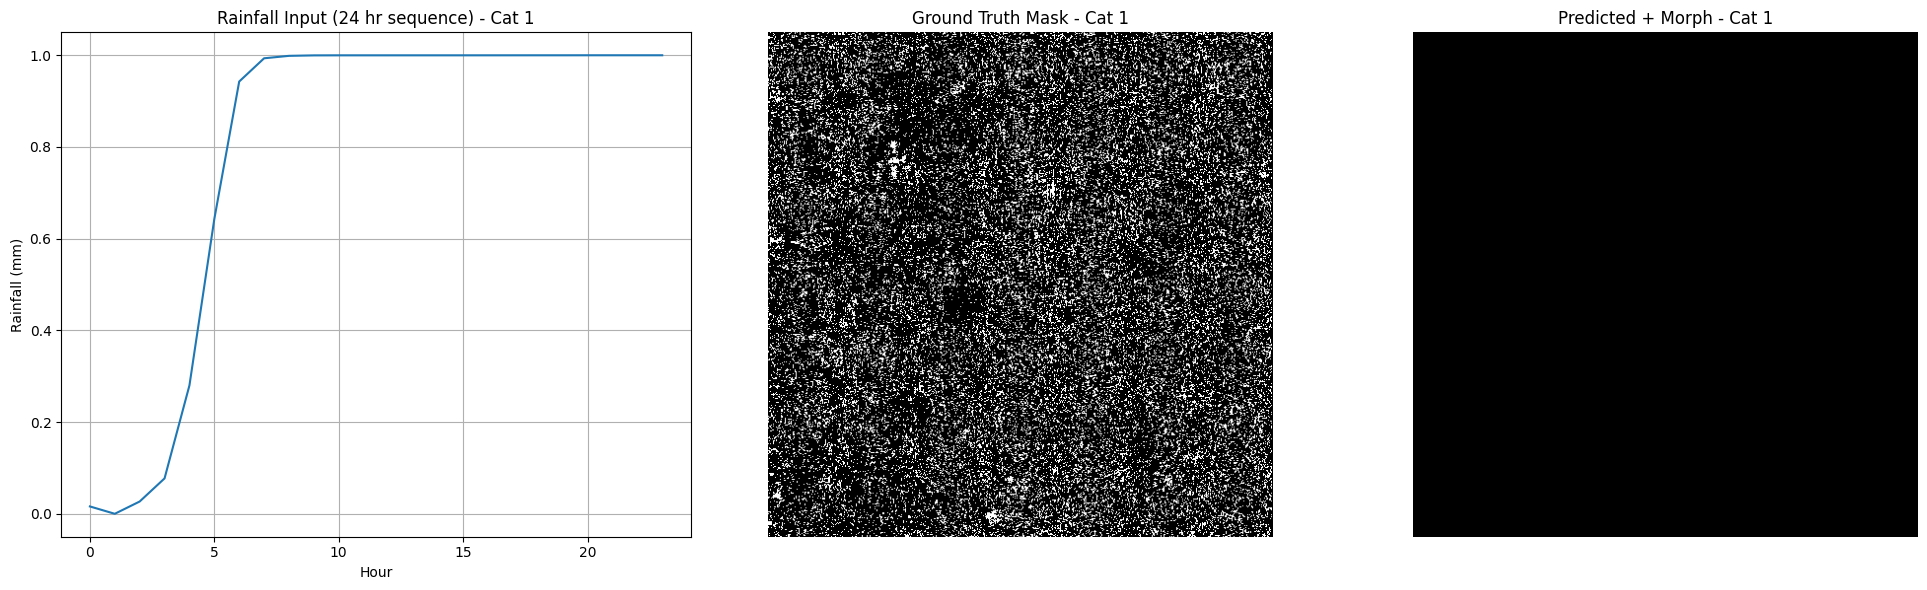

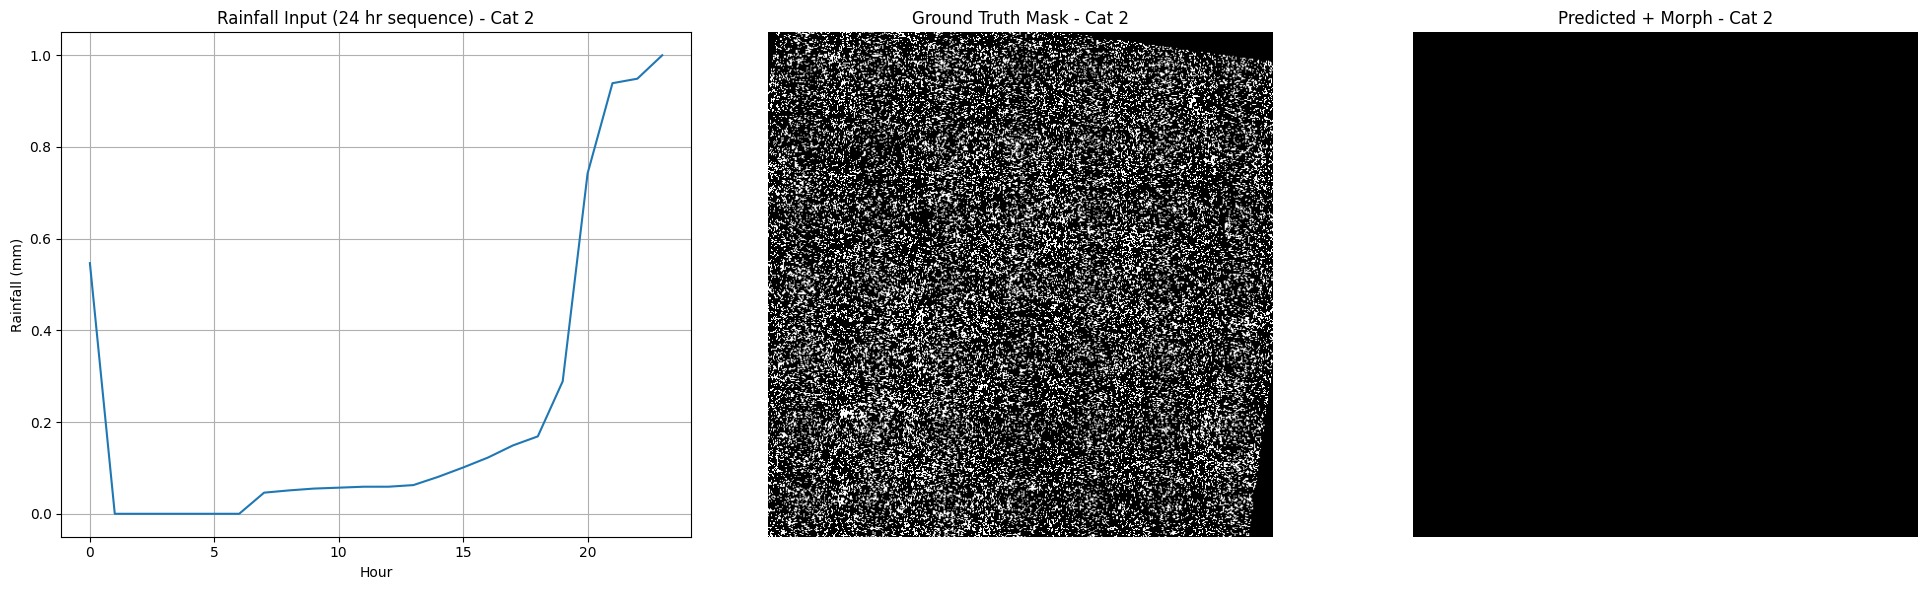

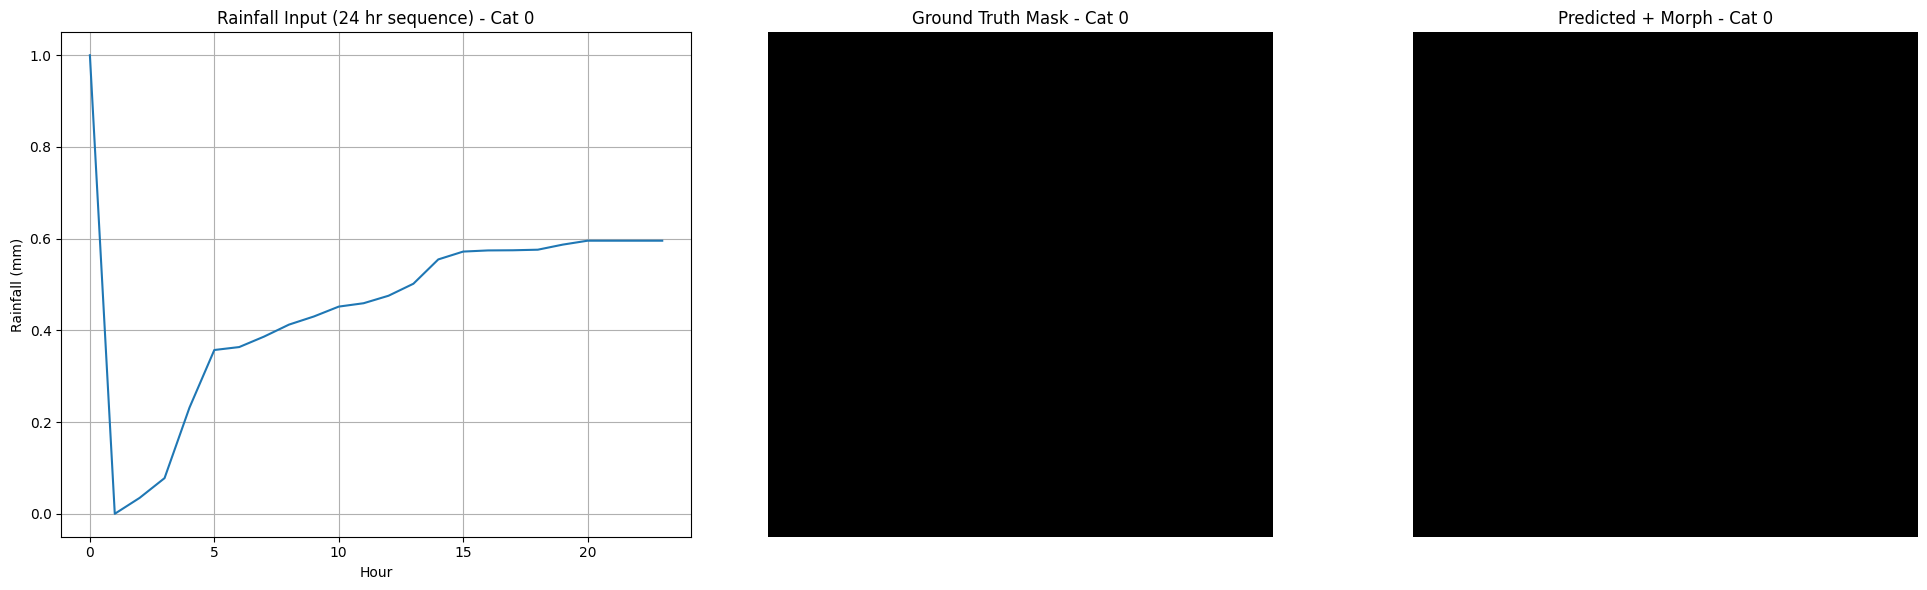

In [ ]:
visualize_full_sample(model, val_loader, device)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.4 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    
    pos_weight_val = trial.suggest_float('pos_weight', 1.0, 5.0)
    gamma = trial.suggest_float('gamma', 1.0, 4.0)
    lambda_bce = trial.suggest_float('lambda_bce', 0.0, 1.0)
    lambda_focal = 1.0 - lambda_bce

    lr = trial.suggest_float('lr', 1e-5, 5e-4)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3)

    gru_hidden = trial.suggest_categorical('gru_hidden', [32, 64, 128])
    gru_layers = trial.suggest_categorical('gru_layers', [1, 2])
    cnn_channels = trial.suggest_categorical('cnn_channels', [32, 64, 128])

    batch_size = trial.suggest_categorical('batch_size', [2, 4, 8])

    model = GRU_UNetPP(
        spatial_in_channels=6,
        rainfall_input_dim=1,
        gru_hidden=gru_hidden,
        gru_layers=gru_layers,
        cnn_channels=cnn_channels
    ).to(device)

    pos_weight_tensor = torch.tensor([pos_weight_val]).to(device)
    criterion = WeightedBCEFocalLoss(
        weight=pos_weight_tensor,
        gamma=gamma,
        lambda_bce=lambda_bce,
        lambda_focal=lambda_focal
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

    for epoch in range(5):
        train(model, train_loader, optimizer, criterion, device)

    _, val_dice, val_iou = evaluate(model, val_loader, criterion, device)


    return 1.0 - val_dice


In [ ]:
import optuna

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial.params)


[I 2025-04-28 05:42:08,808] A new study created in memory with name: no-name-bb0126c9-5eb4-4f34-8eb8-c00f841c56fb
[I 2025-04-28 05:42:18,453] Trial 0 finished with value: 0.7757817506790161 and parameters: {'pos_weight': 3.9274676887024986, 'gamma': 3.1248700615961535, 'lambda_bce': 0.6396897649965633, 'lr': 0.00010812771739791805, 'weight_decay': 0.0007973185030722494, 'gru_hidden': 128, 'gru_layers': 1, 'cnn_channels': 64, 'batch_size': 8}. Best is trial 0 with value: 0.7757817506790161.
[I 2025-04-28 05:42:26,840] Trial 1 finished with value: 0.7656141519546509 and parameters: {'pos_weight': 1.9435310608205505, 'gamma': 1.8382533786674107, 'lambda_bce': 0.8664616371568801, 'lr': 0.00011612267820750926, 'weight_decay': 8.449066689268658e-05, 'gru_hidden': 32, 'gru_layers': 2, 'cnn_channels': 32, 'batch_size': 8}. Best is trial 1 with value: 0.7656141519546509.
[I 2025-04-28 05:42:38,702] Trial 2 finished with value: 0.7798075675964355 and parameters: {'pos_weight': 2.943735027171931,

Best trial:
{'pos_weight': 1.9319485380638863, 'gamma': 2.7929814379728195, 'lambda_bce': 0.5760636375770017, 'lr': 0.00013437287390350995, 'weight_decay': 0.0005450947902343087, 'gru_hidden': 32, 'gru_layers': 2, 'cnn_channels': 128, 'batch_size': 2}


In [ ]:
model = GRU_UNetPP(
    spatial_in_channels=6,
    rainfall_input_dim=1,
    gru_hidden=32,
    gru_layers=2,
    cnn_channels=128
).to(device)


In [ ]:
pos_weight = torch.tensor([1.9319]).to(device)

criterion = WeightedBCEFocalLoss(
    weight=pos_weight,
    gamma=2.7930,
    lambda_bce=0.5761,
    lambda_focal=0.4239
)


In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1.3437e-4,
    weight_decay=5.4509e-4
)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, pin_memory=True)

In [ ]:
import cv2
import numpy as np
from skimage.measure import label

def post_process_mask(binary_mask, min_size=10, kernel_size=3):
  
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    clean = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    labeled_mask, num_features = label(clean, return_num=True)

    output_mask = np.zeros_like(clean)
    for region_id in range(1, num_features + 1):
        region = (labeled_mask == region_id)
        if np.sum(region) >= min_size:
            output_mask[region] = 1

    return output_mask


In [ ]:
best_dice = 0.0

for epoch in range(40):

    train_loss = train(model, train_loader, optimizer, criterion, device)

    val_loss, val_dice, val_iou = evaluate(model, val_loader, criterion, device)


    print(f"Epoch {epoch+1}/40 | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved!")


Epoch 1/40 | Train Loss: 0.4596 | Val Loss: 0.4262 | Val Dice: 0.1514 | Val IoU: 0.1286
✅ Best model saved!
Epoch 2/40 | Train Loss: 0.4404 | Val Loss: 0.3918 | Val Dice: 0.1428 | Val IoU: 0.1226
Epoch 3/40 | Train Loss: 0.4131 | Val Loss: 0.3656 | Val Dice: 0.1514 | Val IoU: 0.1286
Epoch 4/40 | Train Loss: 0.3939 | Val Loss: 0.3417 | Val Dice: 0.4766 | Val IoU: 0.4563
✅ Best model saved!
Epoch 5/40 | Train Loss: 0.3926 | Val Loss: 0.3461 | Val Dice: 0.4853 | Val IoU: 0.4624
✅ Best model saved!
Epoch 6/40 | Train Loss: 0.3934 | Val Loss: 0.3444 | Val Dice: 0.4848 | Val IoU: 0.4620
Epoch 7/40 | Train Loss: 0.3924 | Val Loss: 0.3443 | Val Dice: 0.4847 | Val IoU: 0.4620
Epoch 8/40 | Train Loss: 0.3833 | Val Loss: 0.3376 | Val Dice: 0.4754 | Val IoU: 0.4554
Epoch 9/40 | Train Loss: 0.3920 | Val Loss: 0.3352 | Val Dice: 0.4692 | Val IoU: 0.4504
Epoch 10/40 | Train Loss: 0.3939 | Val Loss: 0.3455 | Val Dice: 0.4850 | Val IoU: 0.4622
Epoch 11/40 | Train Loss: 0.3897 | Val Loss: 0.3305 | Val D

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

@torch.no_grad()
def visualize_predictions(model, loader, device, threshold=0.3):
    model.eval()

    rainfall_batch, spatial_batch, mask_batch, label_batch = next(iter(loader))
    rainfall_batch = rainfall_batch.to(device)
    spatial_batch = spatial_batch.to(device)

    output_batch = model(rainfall_batch, spatial_batch)
    probs_batch = torch.sigmoid(output_batch).cpu().squeeze(1).numpy()
    rainfall_batch = rainfall_batch.cpu().numpy()
    mask_batch = mask_batch.squeeze(1).cpu().numpy()

    fig, axes = plt.subplots(len(rainfall_batch), 3, figsize=(12, len(rainfall_batch)*4))

    if len(rainfall_batch) == 1:
        axes = np.expand_dims(axes, axis=0)

    for idx in range(len(rainfall_batch)):
        rainfall_seq = rainfall_batch[idx].squeeze()
        gt_mask = mask_batch[idx]
        pred_mask = (probs_batch[idx] > threshold).astype(np.uint8)
        pred_mask = post_process_mask(pred_mask)

        axes[idx, 0].plot(np.arange(24), rainfall_seq)
        axes[idx, 0].set_title(f"Rainfall Input - Cat {label_batch[idx].item()}")
        axes[idx, 0].set_xlabel('Hour')
        axes[idx, 0].set_ylabel('Rainfall (normalized)')
        axes[idx, 0].grid(True)

        axes[idx, 1].imshow(gt_mask, cmap='gray')
        axes[idx, 1].set_title(f"Ground Truth Mask - Cat {label_batch[idx].item()}")
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(pred_mask, cmap='gray')
        axes[idx, 2].set_title(f"Predicted Mask - Cat {label_batch[idx].item()}")
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


GRU_UNetPP(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (encoder): Sequential(
    (0): Conv2d(6, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (fusion_fc): Linear(in_features=32, out_features=128, bias=True)
)

In [ ]:
test_loss, test_dice, test_iou = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Dice: {test_dice:.4f} | Test IoU: {test_iou:.4f}")


Test Loss: 0.3428 | Test Dice: 0.5655 | Test IoU: 0.4739


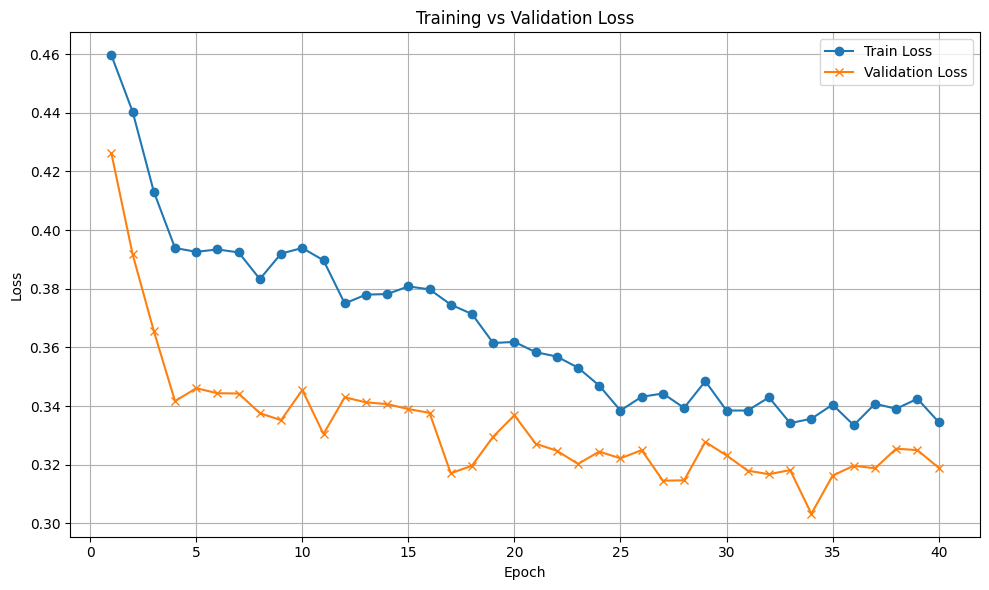

In [ ]:
import matplotlib.pyplot as plt

train_losses = [
    0.4596, 0.4404, 0.4131, 0.3939, 0.3926, 0.3934, 0.3924, 0.3833, 0.3920, 0.3939,
    0.3897, 0.3750, 0.3780, 0.3782, 0.3808, 0.3798, 0.3746, 0.3714, 0.3615, 0.3619,
    0.3584, 0.3569, 0.3531, 0.3470, 0.3385, 0.3432, 0.3443, 0.3394, 0.3485, 0.3385,
    0.3385, 0.3430, 0.3342, 0.3357, 0.3405, 0.3335, 0.3408, 0.3391, 0.3425, 0.3346
]

val_losses = [
    0.4262, 0.3918, 0.3656, 0.3417, 0.3461, 0.3444, 0.3443, 0.3376, 0.3352, 0.3455,
    0.3305, 0.3430, 0.3413, 0.3407, 0.3390, 0.3377, 0.3171, 0.3197, 0.3296, 0.3369,
    0.3272, 0.3248, 0.3203, 0.3245, 0.3222, 0.3250, 0.3146, 0.3147, 0.3278, 0.3232,
    0.3180, 0.3168, 0.3182, 0.3033, 0.3163, 0.3197, 0.3188, 0.3255, 0.3250, 0.3190
]

epochs = list(range(1, 41))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('loss_curve_GU.png', dpi=300)

plt.show()


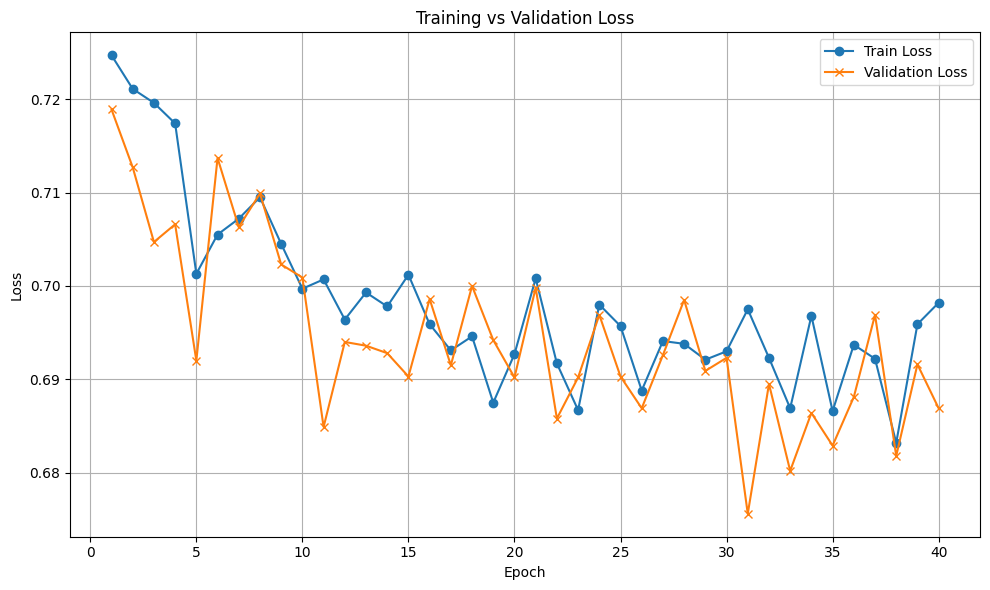

In [ ]:
import matplotlib.pyplot as plt

train_losses = [
    0.7247, 0.7211, 0.7196, 0.7174, 0.7013, 0.7055, 0.7072, 0.7095, 0.7045, 0.6997,
    0.7007, 0.6964, 0.6993, 0.6978, 0.7012, 0.6959, 0.6931, 0.6946, 0.6875, 0.6927,
    0.7008, 0.6917, 0.6867, 0.6980, 0.6957, 0.6888, 0.6941, 0.6938, 0.6921, 0.6930,
    0.6975, 0.6923, 0.6869, 0.6968, 0.6866, 0.6937, 0.6922, 0.6832, 0.6959, 0.6982
]

val_losses = [
    0.7189, 0.7127, 0.7047, 0.7066, 0.6920, 0.7137, 0.7063, 0.7099, 0.7023, 0.7009,
    0.6849, 0.6940, 0.6936, 0.6928, 0.6903, 0.6986, 0.6915, 0.7000, 0.6942, 0.6902,
    0.6998, 0.6858, 0.6902, 0.6969, 0.6903, 0.6869, 0.6926, 0.6985, 0.6909, 0.6923,
    0.6756, 0.6895, 0.6802, 0.6864, 0.6829, 0.6881, 0.6969, 0.6818, 0.6916, 0.6869
]

epochs = list(range(1, 41))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('loss_curve_LD.png', dpi=300)

plt.show()
